# Importing libraries

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.optim import SGD, Adam, lr_scheduler
from copy import deepcopy
from torch.nn.init import xavier_uniform_ as xavier

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Utils

In [4]:
def get_test_accuracy(model, best_model, test_loader):
    model.load_state_dict(best_model)
    size_test = len(test_loader.dataset)

    test_correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.to(device)).cpu()
            predicted = torch.argmax(outputs, dim=1)
            test_correct += (predicted == labels).sum().item()

    print(f"Test accuracy: {test_correct*100/size_test}%")
    return test_correct*100/size_test
            
def plot_accuracy(model, epochs = 2):
    plt.figure()
    plt.plot([i for i in range(epochs)], model.train_accuracy)
    plt.plot([i for i in range(epochs)], model.val_accuracy)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
    plt.title('Accuracy for train and test sets')
    plt.show()

def plot_loss(model, epochs = 2):
    plt.figure()
    plt.plot([i for i in range(epochs)], model.train_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss function value on training set during training')
    plt.show()

def xavier_weights_init(m):
    if isinstance(m, nn.Conv2d):
        xavier(m.weight.data)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [5]:
def load_data(random_seed = 0):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    train_transform = transforms.Compose([                                      
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

    test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

    train, val = random_split(train, [45000, 5000], generator = torch.manual_seed(random_seed))

    train_loader = torch.utils.data.DataLoader(train, batch_size=64,
                                          shuffle=False, num_workers=2,
                                           worker_init_fn=seed_worker)

    val_loader = torch.utils.data.DataLoader(val, batch_size=64,
                                         shuffle=False, num_workers=2,
                                         worker_init_fn=seed_worker)

    test_loader = torch.utils.data.DataLoader(test, batch_size=64,
                                         shuffle=False, num_workers=2,
                                          worker_init_fn=seed_worker)
    
    return train_loader, val_loader, test_loader

In [6]:
def train_cnn(cnn, train_loader, val_loader, test_loader, criterion, optimizer, epochs = 2):
    best_accuracy = -1
    best_model = None
    model.train_loss = list()
    model.train_accuracy = list()
    model.val_accuracy = list()

    size_train = len(train_loader.dataset)
    size_val = len(val_loader.dataset)
    size_test = len(test_loader.dataset)

    for epoch in range(epochs):  

        model.train(True)
        training_loss = 0
        training_correct = 0

        for i, data in enumerate(train_loader, 0):

            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            training_loss += loss.item() * inputs.size(0)
            predicted = torch.argmax(outputs.detach(),dim=1)
            training_correct += (predicted == labels).sum().item()
    
        training_loss = training_loss/size_train
        training_accuracy = training_correct*100/size_train
    
        model.train_loss.append(training_loss)
        model.train_accuracy.append(training_accuracy)

        print(f"Epoch {epoch+1}")
        print(f"Training loss: {training_loss}")
        print(f"Training accuracy: {training_accuracy}%")    

        validation_correct = 0
        model.train(False)
        with torch.no_grad():
            for inputs,labels in val_loader:
                outputs = model(inputs.cuda()).cpu()
                predicted = torch.argmax(outputs.detach(), dim=1)
                validation_correct += (predicted == labels).sum().item()

        val_accuracy = validation_correct*100/size_val
        model.val_accuracy.append(val_accuracy)

        print(f"Validation accuracy: {val_accuracy}%")

        if validation_correct > best_accuracy:
            best_accuracy = validation_correct
            best_model = deepcopy(model.state_dict())

        test_correct = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs.cuda()).cpu()
                predicted = torch.argmax(outputs, dim=1)
                test_correct += (predicted == labels).sum().item()

        print(f"Test accuracy: {test_correct*100/size_test}%")

        scheduler.step()
        print('-'*30)

    print('Finished Training')
    return best_model

# VGG16 pretrained on ImageNet - only last layer changed

In [7]:
class VGG16CNN(nn.Module):
    def __init__(self):
        super(VGG16CNN, self).__init__()
        pretrained_model = models.vgg16_bn(pretrained=True)
        # print(pretrained_model.classifier)
        # change last layer to classify into 10 instead of 1000
        pretrained_model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 10))

        # freeze weights of all the models
        for param in pretrained_model.parameters():
            param.requires_grad = False
        # unfreeze the last layer so it can be trained
        for param in pretrained_model.classifier[6].parameters():
            param.requires_grad = True

        self.pretrained_model = pretrained_model
    
    def forward(self,x):
        x = self.pretrained_model(x)
        return x

In [8]:
train_loader, val_loader, test_loader = load_data(0)
model = VGG16CNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
best_model = train_cnn(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs = 5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1
Training loss: 0.8305161094029745
Training accuracy: 70.9888888888889%
Validation accuracy: 77.32%
Test accuracy: 77.87%
------------------------------
Epoch 2
Training loss: 0.7109052604251438
Training accuracy: 75.00444444444445%
Validation accuracy: 78.78%
Test accuracy: 78.66%
------------------------------
Epoch 3
Training loss: 0.6909681445121765
Training accuracy: 75.74%
Validation accuracy: 79.08%
Test accuracy: 78.84%
------------------------------
Epoch 4
Training loss: 0.692745089424981
Training accuracy: 75.66%
Validation accuracy: 79.02%
Test accuracy: 78.9%
------------------------------
Epoch 5
Training loss: 0.6905946236292522
Training accuracy: 75.9888888888889%
Validation accuracy: 79.02%
Test accuracy: 78.91%
------------------------------
Finished Training


In [13]:
get_test_accuracy(model, best_model, test_loader)

Test accuracy: 78.84%


78.84

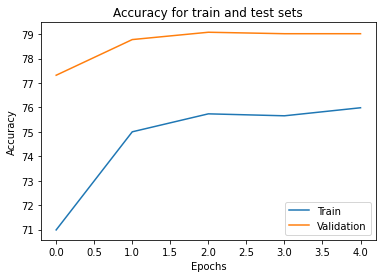

In [14]:
plot_accuracy(model, epochs = 5)

In [ ]:
test_acc = [78.84]
for i in range(1, 3):
    train_loader, val_loader, test_loader = load_data(i)
    model = VGG16CNN().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    best_model = train_cnn(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs = 5)
    test_acc.append(get_test_accuracy(model, best_model, test_loader))
print(test_acc)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth



Epoch 1
Training loss: 0.8355748741785686
Training accuracy: 70.89333333333333%


In [ ]:
print(np.mean(test_acc))

# VGG pretrained on ImageNet - all classification layers changed

In [ ]:
class VGG16CNN(nn.Module):
    def __init__(self):
        super(VGG16CNN, self).__init__()
        pretrained_model = models.vgg16_bn(pretrained=True)
        # print(pretrained_model.classifier)
        # print(pretrained_model.features)

        # change last layer to classify into 10 instead of 1000
        pretrained_model.classifier[6] = nn.Linear(4096, 10)

        # freeze weights of features, train classification layers
        for param in pretrained_model.features.parameters():
            param.requires_grad = False

        self.pretrained_model = pretrained_model
    
    def forward(self,x):
        x = self.pretrained_model(x)
        return x

In [ ]:
test_acc = []
for i in range(3):
    train_loader, val_loader, test_loader = load_data(i)
    model = VGG16CNN().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    best_model = train_cnn(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs = 3)
    test_acc.append(get_test_accuracy(model, best_model, test_loader))
print(test_acc)

In [ ]:
print(np.mean(test_acc))

In [ ]:
plot_accuracy(model)

# VGG without batch normalisation - all classification layers changed

In [ ]:
class VGG16CNN(nn.Module):
    def __init__(self):
        super(VGG16CNN, self).__init__()
        pretrained_model = models.vgg16(pretrained=True)
        # print(pretrained_model.classifier)
        # print(pretrained_model.features)

        # change last layer to classify into 10 instead of 1000
        pretrained_model.classifier[6] = nn.Linear(4096, 10)

        # freeze weights of features, train classification layers
        for param in pretrained_model.features.parameters():
            param.requires_grad = False

        self.pretrained_model = pretrained_model
    
    def forward(self,x):
        x = self.pretrained_model(x)
        return x

In [ ]:
test_acc = []
for i in range(3):
    train_loader, val_loader, test_loader = load_data(i)
    model = VGG16CNN().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    best_model = train_cnn(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs = 3)
    test_acc.append(get_test_accuracy(model, best_model, test_loader))
print(test_acc)

In [ ]:
print(np.mean(test_acc))

In [ ]:
plot_accuracy(model)

# Different optimizer for VGG without batch normalization


In [ ]:
class VGG16CNN(nn.Module):
    def __init__(self):
        super(VGG16CNN, self).__init__()
        pretrained_model = models.vgg16(pretrained=True)

        # change last layer to classify into 10 instead of 1000
        pretrained_model.classifier[6] = nn.Linear(4096, 10)

        # freeze weights of features, train classification layers
        for param in pretrained_model.features.parameters():
            param.requires_grad = False

        self.pretrained_model = pretrained_model
    
    def forward(self,x):
        x = self.pretrained_model(x)
        return x

In [ ]:
for i in range(3):
    train_loader, val_loader, test_loader = load_data(i)
    model = VGG16CNN().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    best_model = train_cnn(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs = 3)
    test_acc.append(get_test_accuracy(model, best_model, test_loader))
print(test_acc)

In [ ]:
print(np.mean(test_acc))

In [ ]:
plot_accuracy(model)